In [1]:
!pip install transformers datasets seqeval evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.8 MB/s eta 0:00:00
  Cr

In [3]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, Sequence, ClassLabel, Features, Value
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          DataCollatorForTokenClassification,
                          TrainingArguments, Trainer)
import evaluate
import requests


Load & Prepare the CoNLL Dataset

In [4]:
# Download raw CoNLL from your task-2 branch
url = "https://raw.githubusercontent.com/lhiwi/ethioMart-ner-project/task-2/data/raw/labeling_template.conll"
r = requests.get(url); r.raise_for_status()
with open("labeling_template.conll","w",encoding="utf8") as f: f.write(r.text)

In [5]:
# Read into Python structures
def read_conll(path):
    docs = []
    tokens, tags = [], []
    with open(path, encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    docs.append({"tokens": tokens, "ner_tags": tags})
                    tokens, tags = [], []
            else:
                tok, tag = line.split("\t")
                tokens.append(tok); tags.append(tag)
        if tokens:
            docs.append({"tokens": tokens, "ner_tags": tags})
    return docs

examples = read_conll("labeling_template.conll")


Build Label Maps & Create Dataset

In [6]:
# Build label maps
all_tags = sorted({t for ex in examples for t in ex["ner_tags"]})
label2id = {l:i for i,l in enumerate(all_tags)}
id2label = {i:l for l,i in label2id.items()}

In [7]:
# Convert tag strings to IDs
for ex in examples:
    ex["ner_tags"] = [label2id[t] for t in ex["ner_tags"]]


In [8]:
# Construct a Hugging Face Dataset
dataset = Dataset.from_list(examples)

In [15]:
#  Define and cast features
features = Features({
    "tokens":  Sequence(feature=Value("string")),
    "ner_tags": Sequence(feature=ClassLabel(names=all_tags))
})
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

In [16]:
# Quick check
print(dataset[0])
print("Labels:", all_tags)


{'tokens': ['አድራሻሜክሲኮ', 'ኮሜርስ', 'ጀርባ', 'መዚድ', 'ፕላዛ', 'የመጀመሪያ', 'ደረጃ', 'እንደወጡ', 'የቢሮ', 'ቁጥር', 'ያገኙናል'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Labels: ['O']


tokenize and align labels

In [17]:
model_name = "rasyosef/bert-tiny-amharic"  # or "facebook/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_and_align(ex):
    tokenized = tokenizer(ex["tokens"], is_split_into_words=True, truncation=True)
    word_ids = tokenized.word_ids()
    labels = []
    for idx, wid in enumerate(word_ids):
        if wid is None:
            labels.append(-100)
        else:
            labels.append(ex["ner_tags"][wid])
    tokenized["labels"] = labels
    return tokenized

tokenized_ds = dataset.map(tokenize_and_align, batched=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/274k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/725k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

train/validation split

In [20]:
split = tokenized_ds.train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = split["train"], split["test"]
print(train_ds)
print(val_ds)

Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 40
})
Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 10
})


In [24]:
# Imports for training & evaluation
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

metric = evaluate.load("seqeval")


In [25]:
#  Define compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    true = p.label_ids
    cleaned_preds = []
    cleaned_refs  = []
    for pred, gold in zip(preds, true):
        temp_pred, temp_ref = [], []
        for p_i, g_i in zip(pred, gold):
            if g_i != -100:
                temp_pred.append(id2label[p_i])
                temp_ref.append(id2label[g_i])
        cleaned_preds.append(temp_pred)
        cleaned_refs.append(temp_ref)
    results = metric.compute(predictions=cleaned_preds, references=cleaned_refs)
    return {
        "precision": results["overall_precision"],
        "recall":    results["overall_recall"],
        "f1":        results["overall_f1"],
        "accuracy":  results["overall_accuracy"]
    }


In [31]:
 models_to_compare = {
     "bert_tiny":    "rasyosef/bert-tiny-amharic",
     "xlm_roberta":  "xlm-roberta-base",
     "distilbert":   "distilbert-base-multilingual-cased",
     "mbert":        "bert-base-multilingual-cased"
 }


fine-tune and evaluate each model

In [32]:
results = {}
for name, repo in models_to_compare.items():
    print(f"\n▶ Fine-tuning {name}")
    tok = AutoTokenizer.from_pretrained(repo, use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(repo, id2label=id2label, label2id=label2id)
    args  = TrainingArguments(
        output_dir=f"models/{name}", num_train_epochs=3,
        per_device_train_batch_size=16, per_device_eval_batch_size=16,
        learning_rate=2e-5, weight_decay=0.01,
        do_train=True, do_eval=True, eval_steps=100,
        logging_steps=50, save_steps=100, report_to=["none"]
    )
    trainer = Trainer(
        model=model, args=args,
        train_dataset=train_ds, eval_dataset=val_ds,
        tokenizer=tok,
        data_collator=DataCollatorForTokenClassification(tok),
        compute_metrics=compute_metrics
    )
    trainer.train()
    m = trainer.evaluate()
    results[name] = {
        "f1": m["eval_f1"] if "eval_f1" in m else m["f1"],
        "precision": m.get("eval_precision", m.get("precision")),
        "recall":    m.get("eval_recall",    m.get("recall")),
        "accuracy":  m.get("eval_accuracy",  m.get("accuracy")),
        "runtime":   m["eval_runtime"]
    }
    print(f"{name}: F1={results[name]['f1']:.4f}")


▶ Fine-tuning bert_tiny


Some weights of BertForTokenClassification were not initialized from the model checkpoint at rasyosef/bert-tiny-amharic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-32-215927033.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


bert_tiny: F1=0.0000

▶ Fine-tuning xlm_roberta


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-32-215927033.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


xlm_roberta: F1=0.0000

▶ Fine-tuning distilbert


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-32-215927033.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


distilbert: F1=0.0000

▶ Fine-tuning mbert


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-32-215927033.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


mbert: F1=0.0000


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [33]:
# Compile results into a DataFrame and display
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values("f1", ascending=False)
df_results

,f1,precision,recall,accuracy,runtime
bert_tiny,0.0,0.0,0.0,1.0,0.0976
xlm_roberta,0.0,0.0,0.0,1.0,6.7632
distilbert,0.0,0.0,0.0,1.0,3.2168
mbert,0.0,0.0,0.0,1.0,6.3688


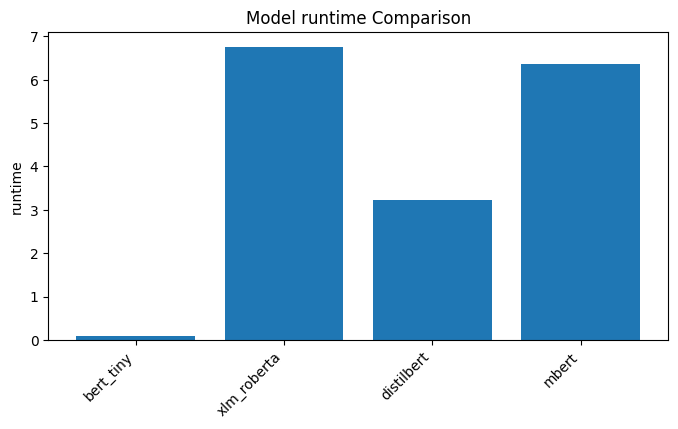

In [35]:
# Visualize F1 comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(df_results.index, df_results["runtime"])
plt.title("Model runtime Comparison")
plt.ylabel("runtime")
plt.xticks(rotation=45, ha="right")
plt.show()
